# Quadratic unconstrained binary optimization (QUBO)

## Example 1

Consider a set of N positive integers (though one doesn't need to) $U = \{n_1, n_2, n_3, \dots, n_N\}$, and imagine the goal is to construct two disjoint subsets of this, called A and B, such that $A\cup B=U$ and $A\cap B=\empty$, such that the sum of the numbers in each subset is equal or as close to each other as possible.

Formally, the sets A and B are to be constructed so that

$$f(\{n_i\}) = (S_A - S_B)^2~~\text{where}$$
$$S_A = \sum_{i\in A} n_i, \quad S_B = \sum_{i\in B}n_i$$

is minimum. This is a `cost function` that has to be minimized.

What we do is, assign to each number $n_i$ a binary variable $x_i$, such that $x_i = 1$ if $n_i\in A$ or otherwise $x_i = 0$ if $n_i \in B$.

Now we can write the partial sum as
$$
S_A = \sum_{i\in U} n_i x_i \\S_B = \sum_{i\in U}n_i (1-x_i)
$$

The cost function can now be written as 

\begin{align}
f(\{n_i\}) &= (S_A - S_B)^2 = S_A^2 + S_B^2 - 2S_A S_B\\
&= (\sum_{i\in U} n_i x_i)^2 + (\sum_{i\in U}n_i (1-x_i))^2 - 2 (\sum_{i\in U} n_i x_i)\sum_{j\in U}n_j (1-x_j)\\
&= \sum_{ij\in U}\left[
    n_i n_j x_i x_j + n_i n_j (1-x_i)(1-x_j) - 2 n_i n_j x_i (1-x_j)
    \right]\\
    &= \sum_{ij\in U} n_i n_j (x_i x_j + 1 - x_i - x_j + x_i x_j - 2x_i + 2 x_i x_j)\\
    &= 4\sum_{ij\in U} n_i n_j x_i x_j - 4\sum_{ij\in U}(n_i n_j x_i) + S^2\\
    &= 4\sum_{ij\in U} n_i n_j x_i x_j - 4S\sum_{i\in U}n_i x_i + S^2 
\end{align}

Where $S_U = \sum_{i\in U} n_i$ is the sum of all the numbers in the set U. Thus we need to minimize the `f` over the discrete space of vector **x** $ = \{x_1, x_2, \dots, x_N\}$. Note that the cost function `f` is quadratic in $x_i$

$$
f(x) = 4\sum_{ij\in U} n_i n_j x_i x_j - 4S\sum_{i\in U}n_i x_i + S^2 
$$


The cost function can be expressed in matrix form as

$$
f(x) = 4 x^{T}Qx + V^{T}x + S^2
$$

where $Q_{ij} = 4n_i n_j$ and $V_i = -4S n_i$

\begin{align}
f(\{n_i\}) = 4\sum_{ij\in U} n_i n_j x_i x_j - 4S\sum_{i\in U}n_i x_i + S^2
\\
= 8\sum_{i>j} n_i n_j x_i x_j
+4\sum_{i}(n_i^2 - S n_i) x_i + S^2 
\end{align}




In [2]:
from typing import Any
import numpy as np

class qubo:

    def __init__(self, ni: np.ndarray) -> None:
        self.ni = np.asarray(ni)
        self.Q = 4 * np.outer(self.ni, self.ni)
        self.S = self.ni.sum()
        self.V = -4 * self.S * self.ni
        self.N = self.ni.shape[0]
    def __call__(self, x: Any) -> float:
        f = x @ (self.Q @ x) + self.V.dot(x) + self.S**2
        return f



In [107]:
import numpy as np
import itertools

# a = np.random.random(6) * 10 + 1
a = np.array([2, 5, 9, 7, 3, 5])
x = np.array([1, 1, 1, 0, 0, 0])
a = a.astype(int)
qfunc = qubo(ni=a)
a == qfunc.ni,a
A = np.array([2,5,9])
B = np.array([7,3,5])
print(qfunc(x), (A.sum()-B.sum())**2)

nsize = 6
il = np.arange(nsize)
q_f = qfunc
vecs = []
dist = []
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)

1 1
separation: (1,5)
separation: (2,4)
separation: (3,3)


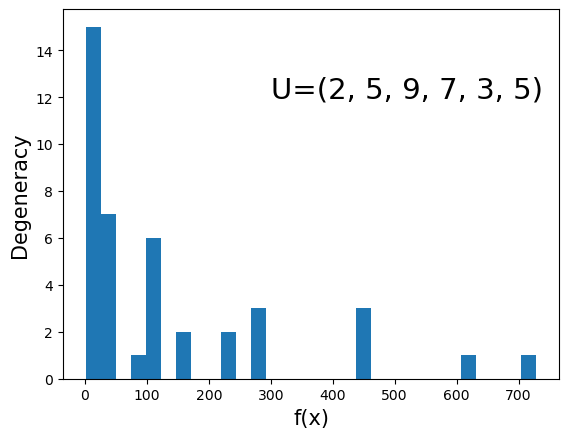

In [108]:
#plt.xlim(0,30000)
toprint = 'U=(' + ', '.join([str(i) for i in a]) + ')'
plt.text(300, 12, toprint, fontsize=21)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
dd = plt.hist(dist, bins=30)

In [110]:
import numpy as np
import itertools

# a = np.random.random(6) * 10 + 1
a = np.array([2, 5, 9, 7, 3, 5, 100])
x = np.array([1, 1, 1, 0, 0, 0, 0])
a = a.astype(int)
qfunc = qubo(ni=a)
a == qfunc.ni,a
A = np.array([2,5,9])
B = np.array([7,3,5, 100])
print(qfunc(x), (A.sum()-B.sum())**2)

nsize = 7
il = np.arange(nsize)
q_f = qfunc
vecs = []
dist = []
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)

9801 9801
separation: (1,6)
separation: (2,5)
separation: (3,4)


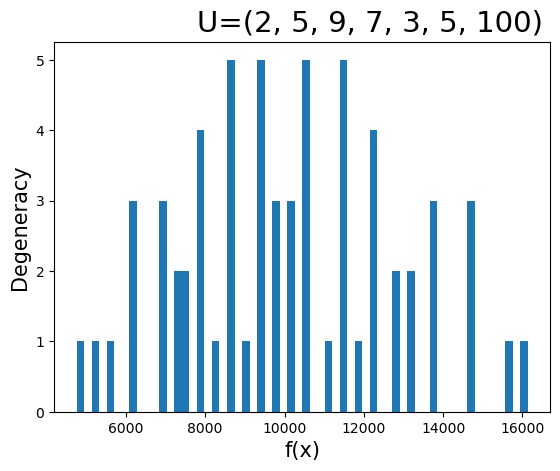

In [121]:
#plt.xlim(0,30000)
toprint = 'U=(' + ', '.join([str(i) for i in a]) + ')'
plt.text(7800, 5.4, toprint, fontsize=21)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
dd = plt.hist(dist, bins=60)

In [33]:
# 2, 5, 9, 7, 3, 5
A = np.array([9,5,2])
B = np.array([7,5,3])
print((A.sum() - B.sum())**2, qfunc(x))

1 1


In [34]:
dist.shape

(1235520,)

In [35]:
x = np.random.randint(0, 2, size=6) # .astype(bool)
print(a, x, qfunc(x))
print(qfunc.ni)
print(qfunc.Q.round(3))
print(qfunc.V)


[2 5 9 7 3 5] [0 0 0 1 0 0] 289
[2 5 9 7 3 5]
[[ 16  40  72  56  24  40]
 [ 40 100 180 140  60 100]
 [ 72 180 324 252 108 180]
 [ 56 140 252 196  84 140]
 [ 24  60 108  84  36  60]
 [ 40 100 180 140  60 100]]
[ -248  -620 -1116  -868  -372  -620]


If $N$ is the number of elements in $U$, then the number of $x$ vectors is

$$
N_{vec} = {}^NC_1 + {}^NC_2 + {}^NC_3 \dots {}^NC_{\frac{N}{2}} = 2^{N-1}
$$


$$
(x+1)^n = {}^NC_0 + {}^NC_1 x + {}^NC_2 x^2 \dots {}^NC_N x^n
$$

$x=1$

$$
2^n = {}^NC_0 + {}^NC_1 + {}^NC_2 \dots {}^NC_N
$$

$x = -1 $

$$
0 = {}^NC_0 - {}^NC_1 + {}^NC_2 \dots + (-1)^N {}^NC_N
$$


In [ ]:
import numpy as np
import itertools
nsize = 21
ni = np.random.randint(1, 30, size=nsize)
# ni = np.array([10, 1, 16, 14, 22, 26, 29, 23, 21, 5, 14, 9, 12, 27, 22, 9, 14, 27, 12, 9, 24])
# ni[-1] = 1500
il = np.arange(nsize)
q_f = qubo(ni=ni)
vecs = []
dist = []
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)


separation: (1,20)
separation: (2,19)
separation: (3,18)
separation: (4,17)
separation: (5,16)
separation: (6,15)
separation: (7,14)
separation: (8,13)
separation: (9,12)
separation: (10,11)


U=(10, 1, 16, 14, 22, 26
29, 23, 21, 5, 14, 9
12, 27, 22, 9, 14, 27
12, 9, 24)


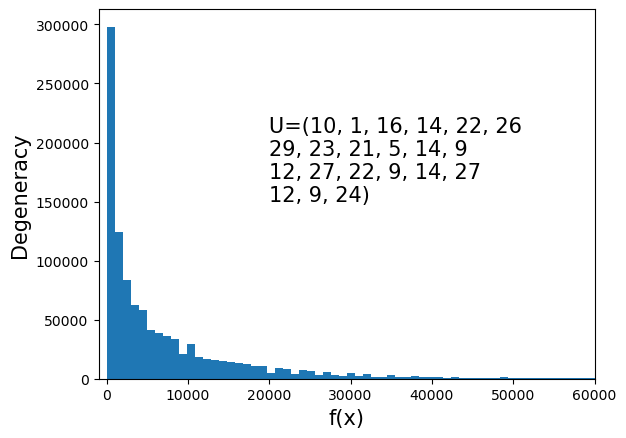

In [154]:
toprint = 'U=('
for i in range(0, ni.shape[0], 6):
    toprint += ', '.join([str(i) for i in ni[i:i+6]]) + '\n'
toprint = toprint[:-1] + ')'
print(toprint)
plt.text(20000, 150000, toprint, fontsize=15)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
plt.xlim(-1000, 60000)
dd = plt.hist(dist, bins=120)

In [155]:
import numpy as np
import itertools
nsize = 21
#ni = np.random.randint(1, 30, size=nsize)
ni[-1] = 1500
il = np.arange(nsize)
q_f = qubo(ni=ni)
vecs = []
dist = []
for choose in range(1,nsize//2+1):
    print(f'separation: ({choose},{nsize-choose})')
    for ii in itertools.combinations(il, choose):
        xi = np.fromiter(((i in ii) for i in il), dtype=bool)
        fi = q_f(xi)
        vecs += [xi]
        dist += [fi]
        #print(ii, xi.astype(int))
vecs = np.array(vecs)
dist = np.array(dist)


separation: (1,20)
separation: (2,19)
separation: (3,18)
separation: (4,17)
separation: (5,16)
separation: (6,15)
separation: (7,14)
separation: (8,13)
separation: (9,12)
separation: (10,11)


U=(10, 1, 16, 14, 22, 26
29, 23, 21, 5, 14, 9
12, 27, 22, 9, 14, 27
12, 9, 1500)


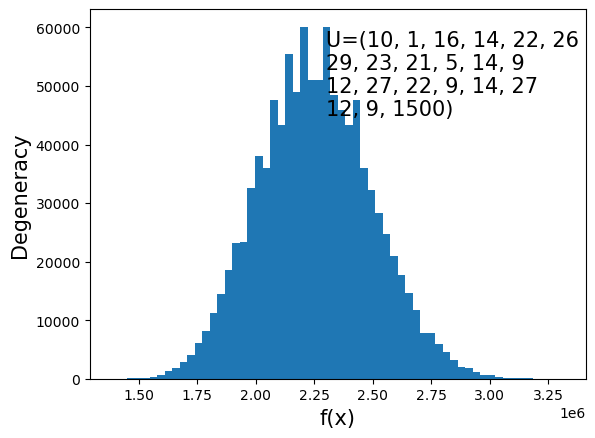

In [173]:
toprint = 'U=('
for i in range(0, ni.shape[0], 6):
    toprint += ', '.join([str(i) for i in ni[i:i+6]]) + '\n'
toprint = toprint[:-1] + ')'
print(toprint)
plt.text(2.3e6, 45000, toprint, fontsize=15)
plt.xlabel('f(x)', fontsize=15)
plt.ylabel('Degeneracy', fontsize=15)
#plt.xlim(-1000, 60000)
dd = plt.hist(dist, bins=60)

In [ ]:
def heuristic_solve(numlist):
    import copy
    N = len(numlist)
    list_copy = copy.deepcopy(list(numlist))
    list_copy.sort()
    set_AB = ([], [])
    ii, cc = 0, 0
    for i in range(N//2):
        x, y = list_copy.pop(0), list_copy.pop(-1)
        set_AB[ii].extend((x, y))
        ii = 1 - ii
        cc += 1
    n = len(list_copy)
    if n == 1:
        set_AB[1].append(list_copy.pop())
    elif n == 2:
        if cc%2 == 0:
            x, y = list_copy
            set_AB[ii].append(y)
            set_AB[1-ii].append(x)
        else:
            x, y = list_copy.pop(), list_copy.pop()
            set_AB[ii].extend((x, y))
    y1, y2 = set_AB
    x = np.asarray([i in y1 for i in numlist])
    # fix this!
    return x, y1, y2


numlist = [3,4,3,6,10,7,12,8,5,6,11, 2, 3]
numlist = [1,2,3,4,5,6,7,8, 12]
numlist = np.random.randint(0, 11, size=100).tolist()
x, y1, y2 = heuristic_solve(np.array(numlist))
print(x.astype(int))
print(len(numlist), numlist)
print(len(y1), y1)
print(len(y2), y2)
print('f_n = ', (sum(y1) - sum(y2))**2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
100 [8, 10, 6, 1, 6, 0, 7, 5, 7, 2, 6, 0, 0, 5, 4, 9, 0, 3, 1, 3, 1, 2, 4, 3, 9, 8, 7, 6, 9, 7, 4, 3, 10, 7, 9, 2, 10, 0, 1, 4, 5, 8, 6, 6, 10, 4, 2, 3, 8, 9, 9, 5, 9, 3, 9, 9, 3, 3, 2, 1, 9, 6, 10, 10, 3, 1, 8, 7, 10, 0, 7, 1, 6, 5, 0, 7, 7, 2, 9, 7, 10, 10, 4, 9, 2, 7, 9, 5, 8, 1, 6, 4, 2, 3, 7, 10, 9, 6, 7, 1]
50 [0, 10, 0, 10, 0, 10, 0, 10, 1, 10, 1, 9, 1, 9, 1, 9, 2, 9, 2, 9, 2, 9, 2, 9, 3, 8, 3, 8, 3, 8, 3, 7, 3, 7, 4, 7, 4, 7, 4, 7, 4, 7, 5, 7, 5, 6, 5, 6, 6, 6]
50 [0, 10, 0, 10, 0, 10, 1, 10, 1, 10, 1, 9, 1, 9, 1, 9, 2, 9, 2, 9, 2, 9, 2, 9, 3, 8, 3, 8, 3, 8, 3, 7, 3, 7, 4, 7, 4, 7, 4, 7, 5, 7, 5, 6, 5, 6, 6, 6, 6, 6]
f_n =  4


In [ ]:
from typing import Any
import numpy as np

class qubo:
    """
    Define QUBO function for set partitioning problem.
    """
    def __init__(self, ni: np.ndarray) -> None:
        self.ni = np.asarray(ni)
        self.N = self.ni.shape[0]        
        self.Q = 4 * np.outer(self.ni, self.ni)
        self.S = self.ni.sum()
        self.V = -4 * self.S * self.ni

    def __call__(self, x: Any) -> float:
        f = x @ (self.Q @ x) + self.V.dot(x) + self.S**2
        return f



In [4]:
print(qubofunc.ni)
print(qubofunc.Q)

[ 3  4  5  6  8 12 11 15]
[[ 36  48  60  72  96 144 132 180]
 [ 48  64  80  96 128 192 176 240]
 [ 60  80 100 120 160 240 220 300]
 [ 72  96 120 144 192 288 264 360]
 [ 96 128 160 192 256 384 352 480]
 [144 192 240 288 384 576 528 720]
 [132 176 220 264 352 528 484 660]
 [180 240 300 360 480 720 660 900]]


In [ ]:
qq = {(i, j): 0.5 * ising.Q[i, j] for i in range(ising.N) for j in range(ising.N)}
bb = dimod.BinaryQuadraticModel(qq, vartype=dimod.SPIN)
print(bb.quadratic)

sampler = dimod.ExactSolver()
sample_set = sampler.sample(bb)
sample_set = sample_set.truncate(5)

print(sample_set)
for sample in sample_set.samples():
    print(sample, ising(sample._data.astype(bool)))

sample._data



In [ ]:
"""
Section 3.1 The Number Partitioning Problem
Partition a set of numbers into two subsets such that the subset sums are as close to each other as possible.
"""

import copy
import dimod
import dwave
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

numbers = [25, 7, 13, 31, 42, 17, 21, 10]
print(numbers)

print("#" * 80)


    


# First try to solve using classical computing / programming naively.
# Sort the list in ascending order and then split it into 2 list based on odd and even index position
numbers_copy = copy.deepcopy(numbers)
numbers_copy.sort()
list1 = numbers_copy[0::2]
list2 = numbers_copy[1::2]
print("Using classical computing / programming")
print("list1: {}, sum: {}".format(list1, sum(list1)))
print("list2: {}, sum: {}".format(list2, sum(list2)))
print("diff: abs(sum(list1) - sum(list2)) = {}".format(abs(sum(list1) - sum(list2))))

# Using classical computing / programming
# list1: [7, 13, 21, 31], sum: 72
# list2: [10, 17, 25, 42], sum: 94
# diff: abs(sum(list1) - sum(list2)) = 22

print("#" * 80)


def split_numbers_list(numbers, result):
    list1 = []
    list2 = []
    for key, include_in_list in result.items():
        index = key - 1
        if include_in_list:
            list1.append(numbers[index])
        else:
            list2.append(numbers[index])
    return list1, list2


c = sum(numbers)
c_square = c ** c

linear = {}
quadratic = {}
offset = 0.0
vartype = dimod.BINARY
for index, value in enumerate(numbers):
    linear[index + 1] = value * (value - c)
for index1, value1 in enumerate(numbers[:-1]):
    for index2 in range(index1 + 1, len(numbers)):
        value = value1 * numbers[index2]
        idx = (index1 + 1, index2 + 1)
        quadratic[idx] = quadratic[tuple(reversed(idx))] = value
# print linear
# print quadratic

# Expected Solution
# x=(0,0,0,1,1,0,0,1), ie list1=[31,42,10]; list2=[25,7,13,17,21]
# y=-6889

bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
sampler = dimod.ExactSolver()
sample_set = sampler.sample(bqm)
sample_set = sample_set.truncate(5)
print("Using ExactSolver()")
print(sample_set)
for sample in sample_set.samples():
    list1, list2 = split_numbers_list(numbers, sample)
    print(
        "list1: {}, sum: {}, list2: {}, sum: {}".format(
            list1, sum(list1), list2, sum(list2)
        )
    )

# Print the first 5 results, notice there are multiple solutions that achieve
# the right answer.
#
# Using ExactSolver()
#    1  2  3  4  5  6  7  8  energy num_oc.
# 0  0  0  0  1  1  0  0  1 -6889.0       1
# 1  0  1  1  0  1  0  1  0 -6889.0       1
# 2  1  1  1  0  0  1  1  0 -6889.0       1
# 3  1  0  0  1  0  1  0  1 -6889.0       1
# 4  1  1  0  1  0  0  1  0 -6888.0       1
# ['BINARY', 5 rows, 5 samples, 8 variables]
# list1: [31, 42, 10], sum: 83, list2: [25, 7, 13, 17, 21], sum: 83
# list1: [7, 13, 42, 21], sum: 83, list2: [25, 31, 17, 10], sum: 83
# list1: [25, 7, 13, 17, 21], sum: 83, list2: [31, 42, 10], sum: 83
# list1: [25, 31, 17, 10], sum: 83, list2: [7, 13, 42, 21], sum: 83
# list1: [25, 7, 31, 21], sum: 84, list2: [13, 42, 17, 10], sum: 82

print("#" * 80)

sampler = dimod.SimulatedAnnealingSampler()
sample_set = sampler.sample(bqm)
sample_set = sample_set.truncate(5)
print("Using SimulatedAnnlearingSampler()")
print(sample_set)
for sample in sample_set.samples():
    list1, list2 = split_numbers_list(numbers, sample)
    print(
        "list1: {}, sum: {}, list2: {}, sum: {}".format(
            list1, sum(list1), list2, sum(list2)
        )
    )

# Using SimulatedAnnlearingSampler()
#    1  2  3  4  5  6  7  8  energy num_oc.
# 0  0  0  0  1  1  0  0  1 -6889.0       1
# 1  1  1  1  0  0  1  1  0 -6889.0       1
# 2  1  1  0  0  1  0  0  1 -6888.0       1
# 3  0  0  0  0  1  1  1  0 -6880.0       1
# 4  0  0  0  0  1  1  1  0 -6880.0       1
# ['BINARY', 5 rows, 5 samples, 8 variables]
# list1: [31, 42, 10], sum: 83, list2: [25, 7, 13, 17, 21], sum: 83
# list1: [25, 7, 13, 17, 21], sum: 83, list2: [31, 42, 10], sum: 83
# list1: [25, 7, 42, 10], sum: 84, list2: [13, 31, 17, 21], sum: 82
# list1: [42, 17, 21], sum: 80, list2: [25, 7, 13, 31, 10], sum: 86
# list1: [42, 17, 21], sum: 80, list2: [25, 7, 13, 31, 10], sum: 86

print("#" * 80)
"""
sampler = EmbeddingComposite(DWaveSampler())
sample_set = sampler.sample(bqm, num_reads=10)
print("Using DWaveSampler()")
print(sample_set)
for sample in sample_set.samples():
    list1, list2 = split_numbers_list(numbers, sample)
    print(
        "list1: {}, sum: {}, list2: {}, sum: {}".format(
            list1, sum(list1), list2, sum(list2)
        )
    )
"""

In [ ]:

"""
class Ising:
    # Define 1D Ising model
    def __init__(self, N=10, Jij=None, h=None) -> None:
        self.Jij = Jij
        self.h, self.N = h, N
        self.Q = np.zeros([self.N, self.N])
        for i in range(self.N-1):
            self.Q[i, i+1], self.Q[i+1, i] = Jij, Jij
        self.x = cp.Variable(self.N, boolean=True)
        self.costfunc = cp.quad_form(self.x, self.Q)#(self.x @ self.Q) @ self.x
        self.objective = cp.Minimize(self.costfunc)
        self.problem = cp.Problem(self.objective)
    def __call__(self, x):
        pass

ising = Ising(6, Jij=1.0)
ising.problem.solve()

def find_best_partition(lst):
    n = len(lst)
    total_sum = sum(lst)
    target_sum = total_sum / 2
    # Define the optimization variable
    x = cp.Variable(n, boolean=True)  # Binary variable representing if an element is in the first partition
    # Define the objective: minimize the absolute difference between partition sums
    subset_sum = cp.sum(cp.multiply(x, lst))
    objective = cp.Minimize(cp.abs(target_sum - subset_sum))
    # Define the problem
    problem = cp.Problem(objective)
    # Solve the problem
    problem.solve()
    # Get the partition results
    x_values = x.value
    first_partition = [lst[i] for i in range(n) if x_values[i] >= 0.5]
    second_partition = [lst[i] for i in range(n) if x_values[i] < 0.5]
    return problem, (first_partition, second_partition)
# Example usage
# lst = [2, 5, 9, 7, 3, 5]
N = 300
lst = np.random.randint(0, 31, N)
lst[-1] = int(lst.sum() * 0.7)
print("full set: ", lst)
problem, (part1, part2) = find_best_partition(lst)
print("First partition:", part1)
print("Second partition:", part2)
print("Sum of first partition:", sum(part1))
print("Sum of second partition:", sum(part2))
"""

In [ ]:
"""
Section 3.1 The Number Partitioning Problem
Partition a set of numbers into two subsets such that the subset sums are as close to each other as possible.
"""

import copy
import dimod
import dwave
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

numbers = [25, 7, 13, 31, 42, 17, 21, 10]
print(numbers)

def split_numbers_list(numbers, result):
    list1 = []
    list2 = []
    for key, include_in_list in result.items():
        index = key - 1
        if include_in_list:
            list1.append(numbers[index])
        else:
            list2.append(numbers[index])
    return list1, list2

print("#" * 80)

c = sum(numbers)
c_square = c ** 2

linear = {}
quadratic = {}
offset = 0.0
vartype = dimod.BINARY
for index, value in enumerate(numbers):
    linear[index + 1] = value * (value - c)
for index1, value1 in enumerate(numbers[:-1]):
    for index2 in range(index1 + 1, len(numbers)):
        value = value1 * numbers[index2]
        idx = (index1 + 1, index2 + 1)
        quadratic[idx] = quadratic[tuple(reversed(idx))] = value
# print linear
# print quadratic

# Expected Solution
# x=(0,0,0,1,1,0,0,1), ie list1=[31,42,10]; list2=[25,7,13,17,21]
# y=-6889

bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

sampler = dimod.ExactSolver()
sample_set = sampler.sample(bqm)
sample_set = sample_set.truncate(5)
"""
print("Using ExactSolver()")
print(sample_set)
for sample in sample_set.samples():
    list1, list2 = split_numbers_list(numbers, sample)
    print(
        "list1: {}, sum: {}, list2: {}, sum: {}".format(
            list1, sum(list1), list2, sum(list2)
        )
    )

sampler = dimod.SimulatedAnnealingSampler()
sample_set = sampler.sample(bqm)
sample_set = sample_set.truncate(5)
print("Using SimulatedAnnlearingSampler()")
print(sample_set)
for sample in sample_set.samples():
    list1, list2 = split_numbers_list(numbers, sample)
    print(
        "list1: {}, sum: {}, list2: {}, sum: {}".format(
            list1, sum(list1), list2, sum(list2)
        )
    )
"""

In [19]:
import dimod

def heuristic_solve(numlist):
    import copy
    N = len(numlist)
    list_copy = copy.deepcopy(list(numlist))
    list_copy.sort()
    set_AB = ([], [])
    ii, cc = 0, 0
    for i in range(N//2):
        x, y = list_copy.pop(0), list_copy.pop(-1)
        set_AB[ii].extend((x, y))
        ii = 1 - ii
        cc += 1
    n = len(list_copy)
    if n == 1:
        set_AB[1].append(list_copy.pop())
    elif n == 2:
        if cc%2 == 0:
            x, y = list_copy
            set_AB[ii].append(y)
            set_AB[1-ii].append(x)
        else:
            x, y = list_copy.pop(), list_copy.pop()
            set_AB[ii].extend((x, y))
    y1, y2 = set_AB
    x = np.asarray([i in y1 for i in numlist])
    # fix this!
    return x, y1, y2

# ni = np.array([3, 4, 5, 6, 8, 12, 11, 15])
# ni = np.array([1,2,3,4,5,6,7,8])

ni = np.random.randint(0, 31, size=15)
ni[-1] = int(ni.mean()*10)
qubofunc = qubo(ni=ni)

qdict = {(i, j): 2*qubofunc.Q[i, j] for i in range(qubofunc.N) for j in range(qubofunc.N) if i>j}
ldict = {i: qubofunc.V[i]+qubofunc.Q[i, i] for i in range(qubofunc.N)}
constant = qubofunc.S**2

bqm_set = dimod.BinaryQuadraticModel(ldict, qdict, offset=constant, vartype=dimod.BINARY)
print(bqm_set.quadratic)
print(bqm_set.linear)

# sampler = dimod.ExactSolver()
sampler = dimod.samplers.SimulatedAnnealingSampler()
sample_set = sampler.sample(bqm_set, num_sweeps=10000)
sample_set = sample_set.truncate(15)

for sample in sample_set.samples():
    xi = sample._data.astype(int)
    fi = qubofunc(xi)
    ia = [k for k, v in sample.items() if v == 0]
    ib = [k for k, v in sample.items() if v == 1]
    print(f"x = {xi}, f(x)={fi}, set A = {ni[ia]}, set B = {ni[ib]}")


print(ni)
x, y1, y2 = heuristic_solve(ni)

print(f"Heuristic result: set A = {y1}, set B = {y2}, {(sum(y1) - sum(y2))**2}")

{(0, 1): 3528.0, (2, 1): 2184.0, (2, 0): 2184.0, (3, 1): 3696.0, (3, 0): 3696.0, (3, 2): 2288.0, (4, 1): 2520.0, (4, 0): 2520.0, (4, 2): 1560.0, (4, 3): 2640.0, (5, 1): 2016.0, (5, 0): 2016.0, (5, 2): 1248.0, (5, 3): 2112.0, (5, 4): 1440.0, (6, 1): 504.0, (6, 0): 504.0, (6, 2): 312.0, (6, 3): 528.0, (6, 4): 360.0, (6, 5): 288.0, (7, 1): 2184.0, (7, 0): 2184.0, (7, 2): 1352.0, (7, 3): 2288.0, (7, 4): 1560.0, (7, 5): 1248.0, (7, 6): 312.0, (8, 1): 4032.0, (8, 0): 4032.0, (8, 2): 2496.0, (8, 3): 4224.0, (8, 4): 2880.0, (8, 5): 2304.0, (8, 6): 576.0, (8, 7): 2496.0, (9, 1): 3192.0, (9, 0): 3192.0, (9, 2): 1976.0, (9, 3): 3344.0, (9, 4): 2280.0, (9, 5): 1824.0, (9, 6): 456.0, (9, 7): 1976.0, (9, 8): 3648.0, (10, 1): 2688.0, (10, 0): 2688.0, (10, 2): 1664.0, (10, 3): 2816.0, (10, 4): 1920.0, (10, 5): 1536.0, (10, 6): 384.0, (10, 7): 1664.0, (10, 8): 3072.0, (10, 9): 2432.0, (11, 1): 3192.0, (11, 0): 3192.0, (11, 2): 1976.0, (11, 3): 3344.0, (11, 4): 2280.0, (11, 5): 1824.0, (11, 6): 456.0, (

In [10]:
x = np.array([1,0,1,0,1,0,1,0])
x = np.array([1,0,0,0,1,1,0,0])
bqm_set.energy(x),qubofunc(x)

(144.0, 144)

array([ 3,  4,  5,  6,  8, 12, 11, 15])